In [4]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import os
%matplotlib inline 

# Load Data

In [5]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/data_for_model"

In [6]:
# function to load data 
def load_appeals_data(root_path=DATAFOLDER):
    csv_path = os.path.join(root_path, "data_for_model_2018-03-23.csv")
    df = pd.read_csv(csv_path)
    return df 

In [7]:
# load data 
df = load_appeals_data(root_path=DATAFOLDER)
df.set_index('idnAppeal', inplace=True) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253850 entries, 4657002 to 5021568
Data columns (total 15 columns):
nat_string             253688 non-null object
strCustody             212251 non-null object
strProbono             578 non-null object
case_type_string       253848 non-null object
ij_code                253850 non-null object
lawyer                 253850 non-null int64
defensive              248004 non-null float64
affirmative            248004 non-null float64
oral                   253354 non-null float64
written                253354 non-null float64
comp_year              253850 non-null int64
osc_year               253850 non-null float64
input_year             253839 non-null float64
datAppealFiled_year    253850 non-null float64
granted                253850 non-null int64
dtypes: float64(7), int64(3), object(5)
memory usage: 31.0+ MB


# Data Pipelines

In [8]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [9]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [10]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [11]:
# method to subset data for training model 
def get_model_data(df, label, cat_features, num_features, impute_methods): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, df[f].dropna().unique().tolist()) for f in cat_features]) # do EDA and limit to smaller list 
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [12]:
# method to output evaluation metrics and plot ROC curve 

def evaluate_model(truth, pred, plot_auc): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss}
    if plot_auc: 
        plt.plot(fpr, tpr, label= 'AUC = {0:.3f}'.format(roc_auc)) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
    else: pass 
    return metrics 

In [13]:
# method to train a model, output results, and plot AUC 

def train_model(model, plot_auc=True, print_metrics=True): 
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(y_test.values.ravel(), y_pred, plot_auc)
    if print_metrics: 
        print(metrics)
    return model, metrics 

# Test Different Variables 

#### One Variable  

Training Data: (203080, 218) | Test Data: (50770, 218)
{'Accuracy': 0.6932834350994682, 'ROC AUC': 0.6621813078337491, 'Log Loss': 0.5867556479371109}


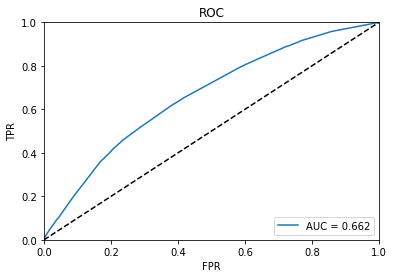

In [14]:
# nationality only 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 422) | Test Data: (50770, 422)
{'Log Loss': 0.5983293739530241, 'ROC AUC': 0.62669774393826994, 'Accuracy': 0.69040772109513493}


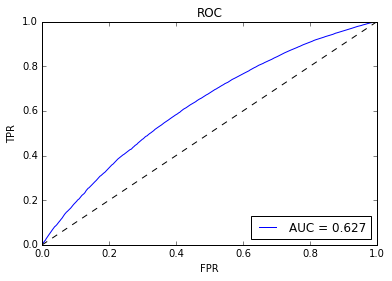

In [22]:
# judge only 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 1) | Test Data: (50770, 1)
{'Log Loss': 0.6092270840465136, 'ROC AUC': 0.58421742872353233, 'Accuracy': 0.69052590112271028}


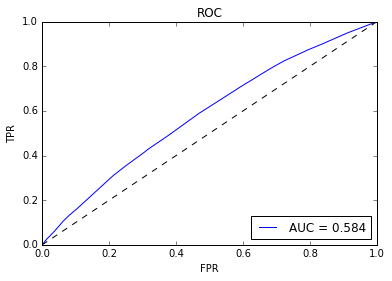

In [23]:
# appeal year only
CAT_FEATURES = []
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Two Variables 

Training Data: (203080, 640) | Test Data: (50770, 640)
{'Log Loss': 0.85104430667397435, 'ROC AUC': 0.69865356060093564, 'Accuracy': 0.71288162300571201}


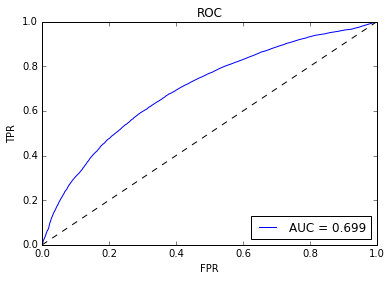

In [24]:
# nationality + judge 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 219) | Test Data: (50770, 219)
{'Log Loss': 0.60162880847940703, 'ROC AUC': 0.72426927117404194, 'Accuracy': 0.73269647429584395}


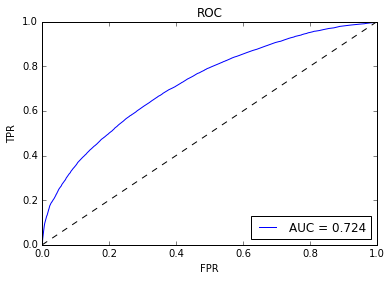

In [25]:
# nationality + appeal year 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 423) | Test Data: (50770, 423)
{'Log Loss': 0.64653412340535987, 'ROC AUC': 0.6743846275717359, 'Accuracy': 0.70275753397675789}


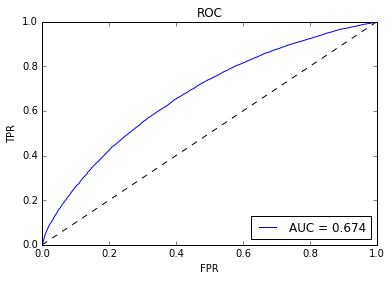

In [26]:
# judge + appeal year 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Multiple Variables  

Training Data: (203080, 641) | Test Data: (50770, 641)
{'Log Loss': 1.4266248933175403, 'ROC AUC': 0.75283281975974548, 'Accuracy': 0.7480204845381131}


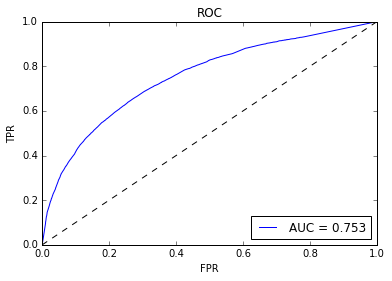

In [27]:
# nationality + judge + appeal year 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 646) | Test Data: (50770, 646)
{'Log Loss': 1.4605113632891873, 'ROC AUC': 0.75962785488448192, 'Accuracy': 0.75148709868032304}


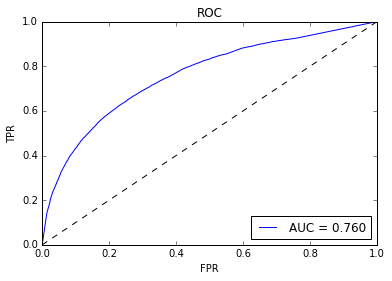

In [28]:
# nationality + judge + appeal year + case type 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'case_type_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 650) | Test Data: (50770, 650)
{'Log Loss': 1.5204082216210542, 'ROC AUC': 0.76500365454167485, 'Accuracy': 0.75387039590309235}


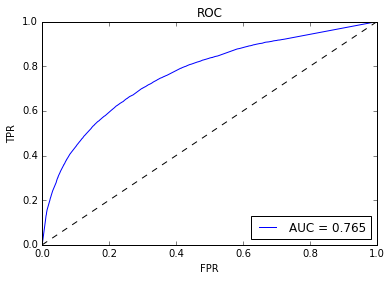

In [29]:
# nationality + judge + appeal year + case type + custody + probono
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none'}  
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 655) | Test Data: (50770, 655)
{'Log Loss': 1.4517462719985745, 'ROC AUC': 0.77320921286748912, 'Accuracy': 0.76054756746109908}


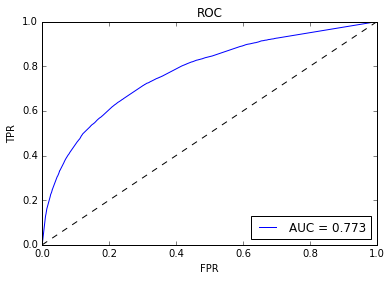

In [30]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 658) | Test Data: (50770, 658)
{'Log Loss': 1.3334179815737204, 'ROC AUC': 0.7971307778498814, 'Accuracy': 0.77443372070120153}


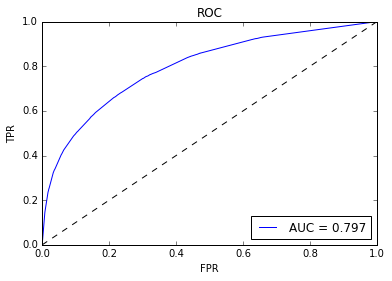

In [31]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written 
# + comp/osc/input years 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 658) | Test Data: (50770, 658)
{'Accuracy': 0.7853456765806579, 'ROC AUC': 0.8171916344468901, 'Log Loss': 0.6411585427893894}


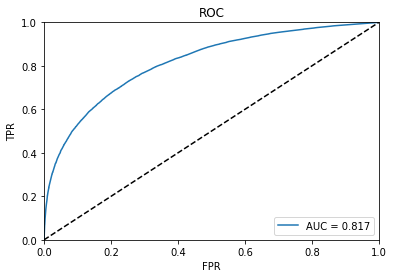

In [15]:
# same as above but more trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

# Feature Importance 

In [79]:
feature_importances = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(20)

datAppealFiled_year               0.131154
comp_year                         0.081384
osc_year                          0.075198
input_year                        0.073703
nat_string:::EL SALVADOR          0.024503
nat_string:::HAITI                0.017218
lawyer                            0.012808
strCustody:::N                    0.010352
nat_string:::CHINA                0.009442
case_type_string:::DEPORTATION    0.009173
nat_string:::GUATEMALA            0.009117
strCustody:::R                    0.008325
nat_string:::NICARAGUA            0.008021
strCustody:::D                    0.007158
affirmative                       0.006643
defensive                         0.006612
oral                              0.006365
nat_string:::IRAQ                 0.006048
written                           0.005461
nat_string:::INDIA                0.005211
dtype: float64

In [80]:
#TODO: Group dummy variables that are not well-represented in dataset 
feature_importances.tail(20)

ij_code:::TRE                                  1.069683e-06
nat_string:::SAMOA                             1.031292e-06
nat_string:::TURKS AND CAICOS ISLANDS          8.751231e-07
nat_string:::BRITISH INDIAN OCEAN TERRITORY    8.716498e-07
ij_code:::BSC                                  8.511310e-07
nat_string:::MALDIVES                          8.313914e-07
nat_string:::SWAZILAND                         8.085162e-07
nat_string:::NAURU                             7.450112e-07
nat_string:::MARTINIQUE                        5.482767e-07
nat_string:::FAEROE ISLAND                     3.868054e-07
ij_code:::CAH                                  3.590321e-07
nat_string:::BRITISH VIRGIN ISLANDS            2.387229e-07
nat_string:::PEOPLE'S REPUBLIC OF BENIN        1.784552e-07
ij_code:::EHM                                  1.131679e-07
ij_code:::JCO                                  2.704272e-08
nat_string:::MONACO                            0.000000e+00
ij_code:::SMN                           

In [85]:
# Collapse feature importances for dummy variables onto their respective parent 
def collapse_feature_importances(feature_importances): 
    """ Takes a pd.Series representing feature importances of all input variables including dummies 
        Returns a pd.Series representing feature importances where those dummies are collapsed into parent variable 
        Assumes ':::' was used as separator in one-hot-encoding 
    """
    cfi = pd.DataFrame(feature_importances).reset_index().rename(
        columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    return cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 

In [86]:
collapsed_feature_importances = collapse_feature_importances(feature_importances)
collapsed_feature_importances

parent_feature
ij_code                0.345685
nat_string             0.209835
datAppealFiled_year    0.131154
comp_year              0.081384
osc_year               0.075198
input_year             0.073703
strCustody             0.025835
case_type_string       0.018296
lawyer                 0.012808
affirmative            0.006643
defensive              0.006612
oral                   0.006365
written                0.005461
strProbono             0.001019
Name: importance, dtype: float64

# Partial Dependence Plots

In [44]:
from pdpbox import pdp

def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=1000, plot_samples=200): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # if feature is categorical, generate list of dummy variable names, else use feature name 
    if feature_is_cat: 
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

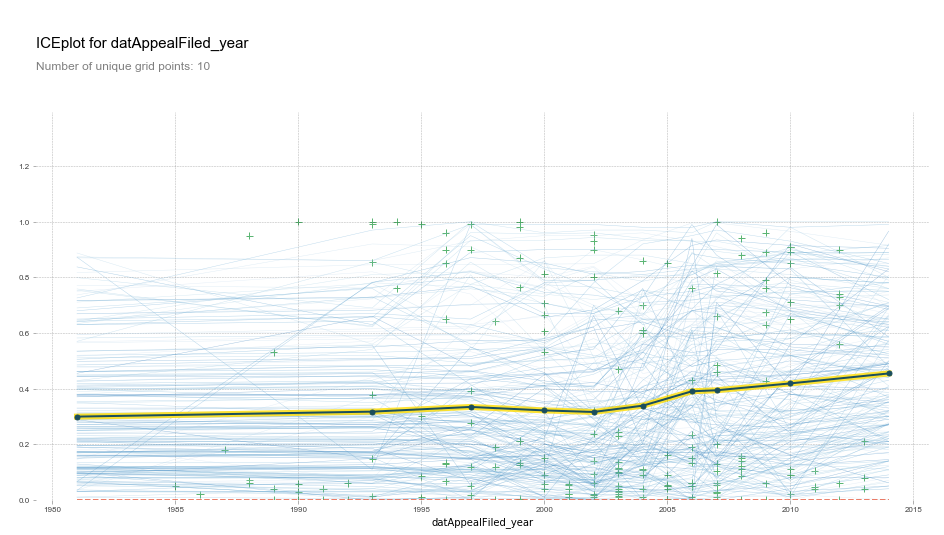

In [45]:
pdp_plot(model, X_train, 'datAppealFiled_year', feature_is_cat=False)

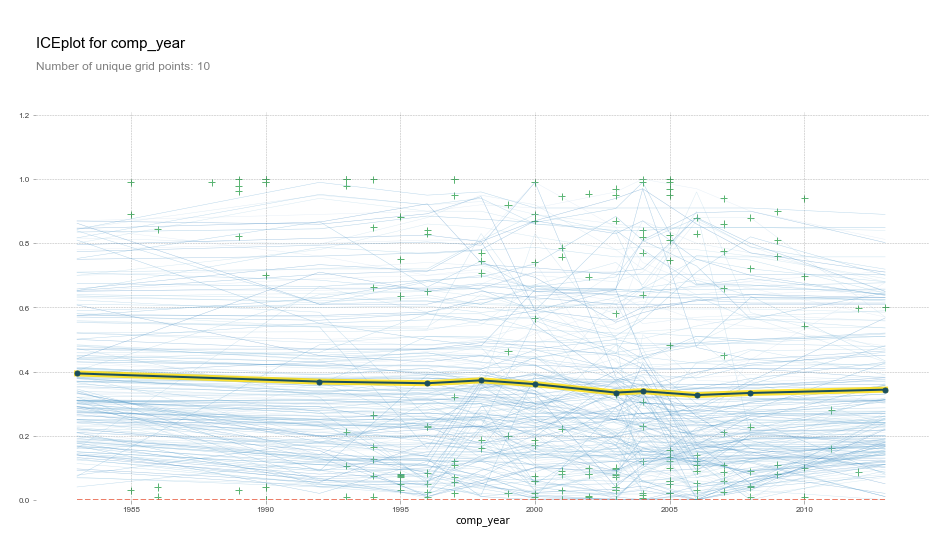

In [46]:
pdp_plot(model, X_train, 'comp_year', feature_is_cat=False)

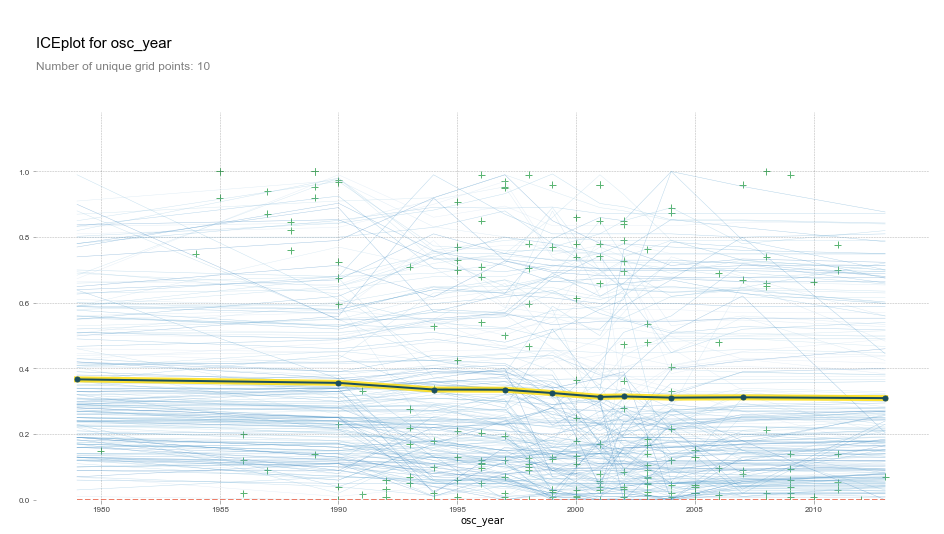

In [47]:
pdp_plot(model, X_train, 'osc_year', feature_is_cat=False)

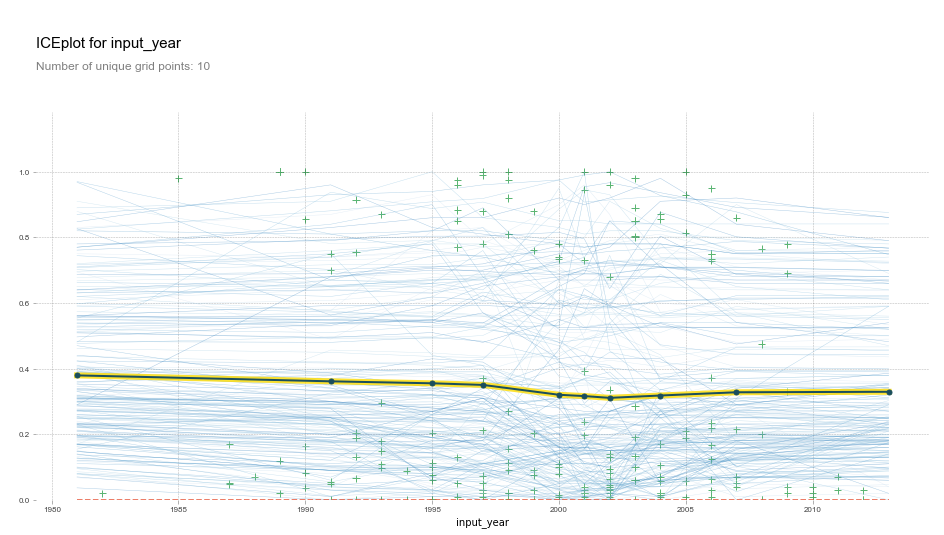

In [48]:
pdp_plot(model, X_train, 'input_year', feature_is_cat=False)

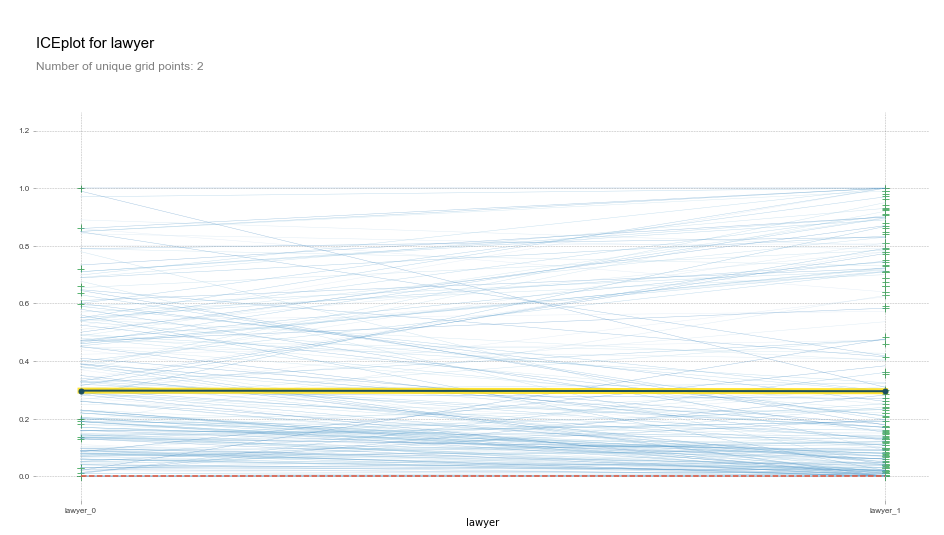

In [51]:
pdp_plot(model, X_train, 'lawyer', feature_is_cat=False)

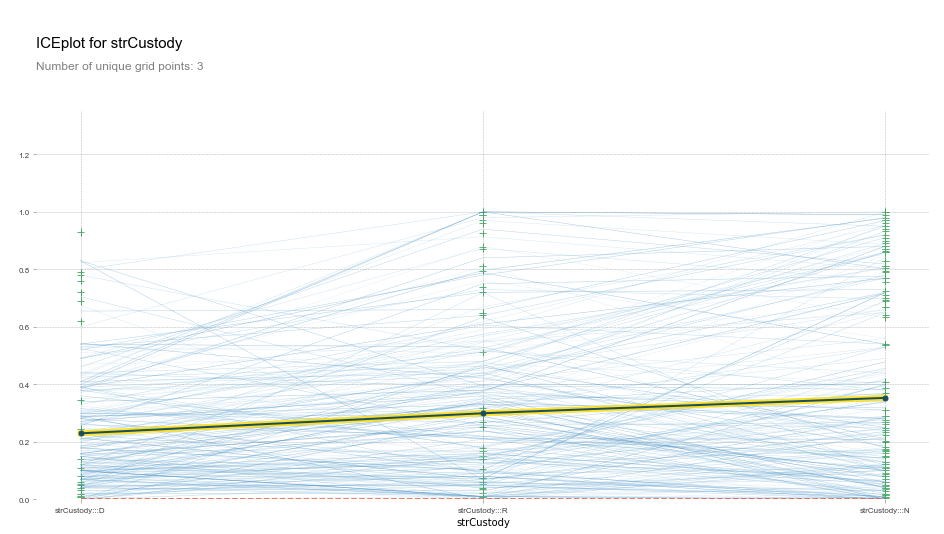

In [49]:
pdp_plot(model, X_train, 'strCustody', feature_is_cat=True)

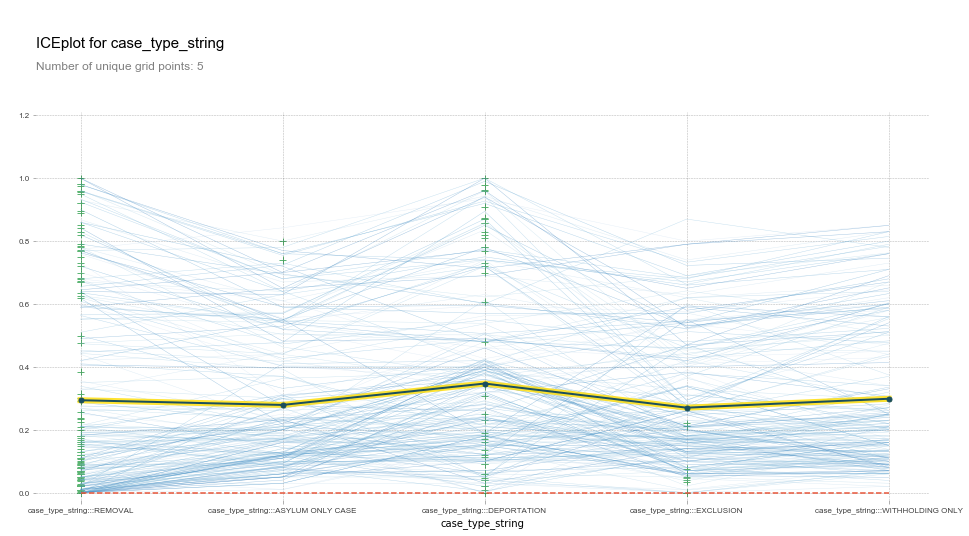

In [53]:
pdp_plot(model, X_train, 'case_type_string', feature_is_cat=True)

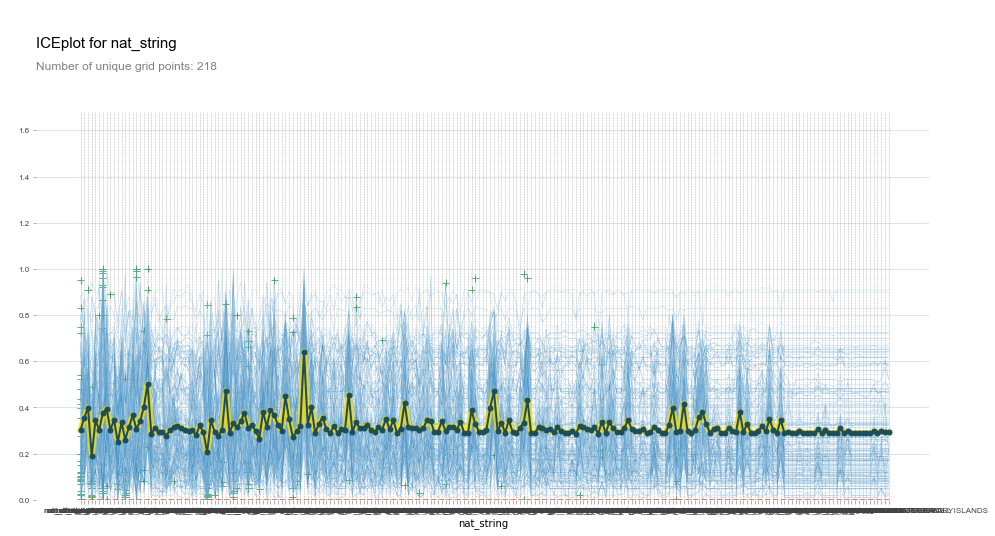

In [50]:
# TODO: reduce dimensionality of nat_string 
pdp_plot(model, X_train, 'nat_string', feature_is_cat=True)

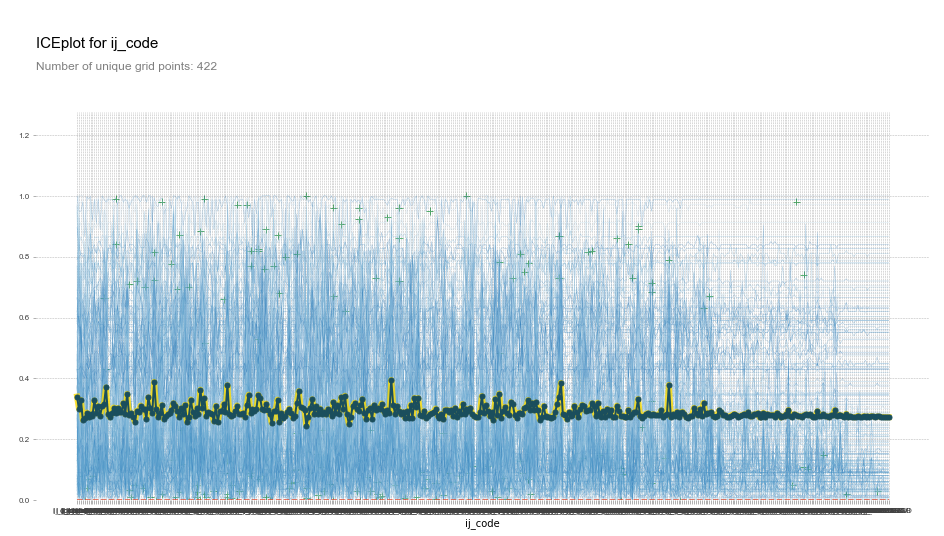

In [52]:
# TODO: reduce dimensionality of ij_code / use clusters? 
pdp_plot(model, X_train, 'ij_code', feature_is_cat=True)